In [1]:
import numpy as np
import os
import os.path as osp
import matplotlib.pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [2]:
sns.set(font_scale=1.6)

In [3]:
# Random seeds for reproducibility
np.random.seed(123)
start_time = time.time()

In [4]:
#####################################################################
## Function to sample sojourn time and output departure time
#####################################################################
def statefunction(stateI, tI, t_max):
    ##define transition rate prameters
    gamma = 2.8e-5
    lamda = 7.26e-5
    
    ####given state0
    if stateI == 0:        
        #use inverse transform sampling
        U = np.random.uniform(0,1,1)
        tO = np.sqrt(tI**2-2/(2*gamma+lamda)*np.log(1-U))
        
    ####given state1
    if stateI == 1:
        #use inverse transform sampling
        U = np.random.uniform(0,1,1)
        tO = np.sqrt(tI**2-2/(gamma+lamda)*np.log(1-U))
        
    ####given state2
    if stateI == 2:
        #print('stateI == 2, END')
        tO = t_max
        
    return float(tO) #output departure time

#### Function to define the state transition 

In [5]:
def tranfunction(stateI, tO):
    stateI = int(stateI)
    tO=float(tO)
    #define transition rate prameters
    gamma = 2.8e-5*tO
    lamda = 7.26e-5*tO
    
    #specify transition rates across state
    phi01=2*gamma
    phi02=lamda
    phi12=gamma+lamda

    #following departure
    #calculate transition probability
    ####given state1
    if stateI == 0:
        #probability
        tranAll = phi01+phi02
        tranP = [phi01/tranAll,phi02/tranAll]
        tranS = [1,2]
        tranResult = np.matrix([tranS,tranP]).transpose()
       
    ####given state1
    if stateI == 1:
        #probability
        tranAll = phi12
        tranP = 1
        tranS = 2
        tranResult = np.matrix([tranS,tranP])
        
    ####given state2
    if stateI == 2:
        print('NULL Transition out from State-2')
        
    
    ####generate a random number from uniform [0,1]
    u = np.random.uniform(0,1,1)
    #sum the transition probability
    sumTransP = np.cumsum(tranResult[:,1])
    #determine the index of state out
    idx = np.sum((u>=sumTransP)+ 0)+1 #+0 convert boolean to numeric
    
    #result
    stateOut = tranResult[idx-1,0]
    final_ret = [stateOut]
    
    return final_ret

#### Run Monte Carlo Simulations

In [6]:
#number of replications
N_max = int(1e6)
#time horizon
t_max = 3e2 + 1

## Initialize storage
all_list = np.empty((0,2), int)

## Initialize no. of replication

sample_trace = []
for n_rep in tqdm(range(1, N_max+1)):
    
    #print(n_rep/N_max)
    
    #initialize time
    t_in_A = [0.]
    #initialize state
    state_in_A = [0]
  
    while (t_in_A[-1] < t_max):
        t_in = t_in_A[-1]
        state_in = state_in_A[-1]
        t_out = statefunction(state_in, t_in, t_max)
        
        if state_in==2:
            #print('state_in==2')
            t_in_A = np.append(t_in_A, t_max)
            state_in_A = np.append(state_in_A, 2)
            
        else:
            state_out = tranfunction(state_in, t_out)
            #update
            t_in_A = np.append(t_in_A, t_out)
            state_in_A = np.append(state_in_A, state_out[0])
    
        sample_trace.append([n_rep, state_in, t_in, t_out])

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:51<00:00, 8930.65it/s]


#### Data analytics to derive state probability

In [7]:
df = pd.DataFrame(sample_trace, columns=['sample_id', 'state', 't_in', 't_out'])

In [8]:
time_idx = np.arange(0, t_max, 1)

In [9]:
state_probs = []

for i in tqdm(range(len(time_idx))):
    t = time_idx[i]
    
    groups = df[(df['t_in'] <= t) & (df['t_out'] > t)].groupby('state')['sample_id'].groups.keys()
    res = df[(df['t_in'] <= t) & (df['t_out'] > t)].groupby('state')['sample_id'].count().values
    
    j = 0
    states = np.zeros(3)
    for key in groups:
        states[int(key) - 1] = res[j]/N_max
        j += 1

        
    state_probs.append(list(states))

100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [00:32<00:00,  9.21it/s]


In [10]:
state_probs = np.array(state_probs)

df_res = pd.DataFrame()
df_res['time'] = time_idx
df_res['state_0'] = state_probs[:, 0]
df_res['state_1'] = state_probs[:, 1]
df_res['state_2'] = state_probs[:, 2]

In [11]:
df_res.to_csv("MCS_non_homo_300.csv", index = False)

In [12]:
#####################################################################
## used time
#####################################################################
end_time = time.time() 
used_time = end_time - start_time
print("--- %s seconds ---" % (used_time))

--- 145.79742884635925 seconds ---


#### Visualization

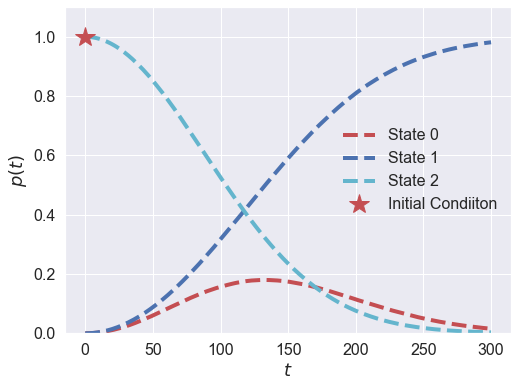

In [13]:
######################################################
## Plotting
######################################################
plt.figure(figsize=(8,6))
plt.plot(time_idx, state_probs[:,0:1], 'r--', linewidth = 4, label = "State 0")
plt.plot(time_idx, state_probs[:,1:2], 'b--', linewidth = 4, label = "State 1")
plt.plot(time_idx, state_probs[:,2:3], 'c--', linewidth = 4, label = "State 2", markersize=20)
plt.plot(0, 1, 'r*', linewidth = 4, label = "Initial Condiiton", markersize=20)
plt.legend(frameon=False,fontsize=16)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$p(t)$', fontsize=18)
# plt.xlim([-1,30])
plt.ylim([0,1.1])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

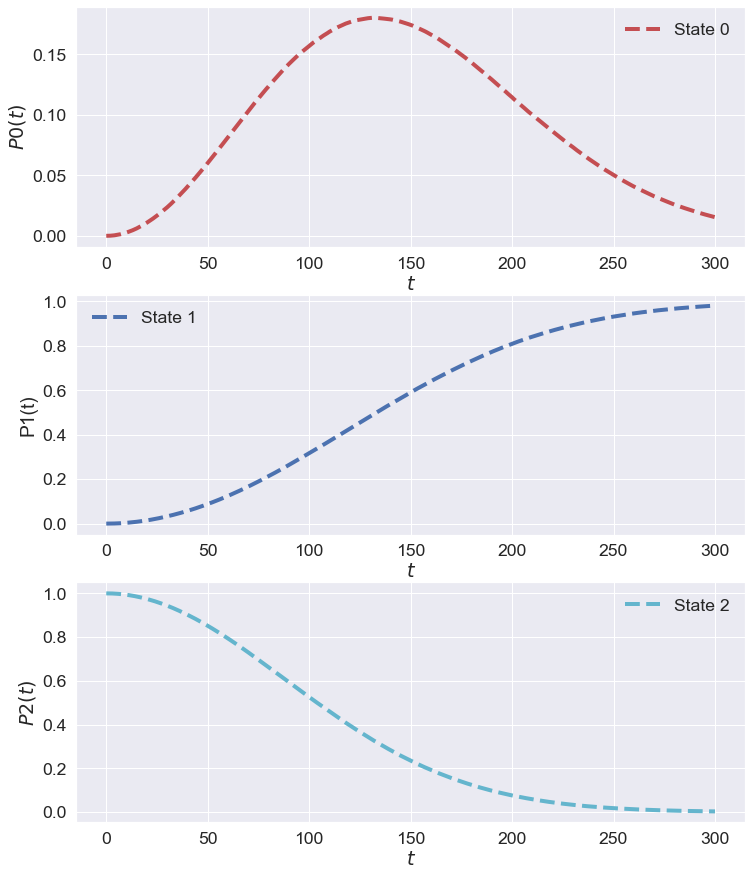

In [14]:
######################################################
## subplot
######################################################
ax = plt.figure(1,figsize=(12, 15))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(3, 1, 1)
plt.plot(time_idx, state_probs[:,0:1], 'r--', linewidth = 4, label = "State 0")
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('$P0(t)$')

plt.subplot(3, 1, 2)
plt.plot(time_idx, state_probs[:,1:2], 'b--', linewidth = 4, label = "State 1")
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('P1(t)')

plt.subplot(3, 1, 3)
plt.plot(time_idx, state_probs[:,2:3], 'c--', linewidth = 4, label = "State 2")
plt.legend(frameon=False)
plt.xlabel('$t$')
plt.ylabel('$P2(t)$')

plt.show()